In [7]:
using Gurobi, Cbc, Mosek, PyPlot, JuMP, Ipopt

raw = readcsv("Book3.csv");
# print(raw[3,4])
trackx = length(raw[:,1])
tracky = length(raw[1,:])

#track specs
starttrack = 28
finishtrack = 242
maintrack = 0
backgroundtrack = 255

function FindPath(CorPos)


        ## Tyre specs
        coflo = 0.2 #coeffecient of friction longitudnal(in direction of motion)
        cofla = 0.4 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)


        ## formula one car specs all specs in meters and seconds
        # mass = 1000 # in kg
        g = 9.8  # gravitational pull in m/sec^2
        maxacc = 14.2 # max acc in m/sec^2
        maxv = 103.55 # max velocity in m/sec equivalent to 200km/hr
        maxTu = 1.27 #max steer one side


        ##model
        m = Model(solver = IpoptSolver(print_level=0))
        # m = Model(solver = GurobiSolver())

        ## Start ad Finish constraints
        k =50 #28 optimal
        startPos = [50,1]
        finishPos = [1000, 650]
        startVel = [0,0]
        finishVel = [0,0]
        startAccDM = [0,0]
        startAccCent = [0,0]
        finishAccDM = [0,0]

        ## Basic variables and their constraints
        @variable(m, P[1:2,1:k])  # resulting position in x,y
        @variable(m, v[1:2,1:k])
        @variable(m, -2.75*maxacc <= Thrust[1:k] <= maxacc)  # thruster input
        @variable(m, AccDM[1:2,1:k])
        @variable(m, AccDMBeta[1:k])
        @variable(m, AccCent[1:2,1:k])

        for i in 1:length(CorPos[1,:])   
                temp = round(Int64,CorPos[1,i])
                if temp == 0
                temp = temp+1
            end
     
                setvalue(P[1,temp], CorPos[2,i]) 
                setvalue(P[2,temp], CorPos[3,i])  
        #         print([CorPos[1,i]])
        #         print([CorPos[2,i]])
        end    


        @constraint(m, P[:,1] .== startPos)
            @constraint(m, P[2,:] .>= 0)
              @constraint(m, P[1,:] .>= 0)
    
                @constraint(m, P[2,:] .<= 1300)
              @constraint(m, P[1,:] .<= 1000)
    
#                   @constraint(m, P[2,18] >= 1200)

        @constraint(m, v[:,1] .== startVel)
        @constraint(m, AccCent[:,1] .== startAccCent)
        # @constraint(m, AccDM[:,1] .== startAccDM)
        @constraint(m, P[:,k] .== finishPos)
        # @constraint(m, v[:,k] .== finishVel)
        # @constraint(m, AccDM[:,k] .== finishAccDM)
        # @NLexpression(m, finishDistance, sum((P[i,k]-finishPos[i])^2 for i in 1:2))
        # @NLexpression(m, AccCentripital, sum((AccCent[1,i]^2)+(AccCent[2,i]^2)-(cofla*g)^2 for i in 1:k))

        ## motion constraints
        for t in 1:k
            @NLconstraint(m, AccDM[1,t]*AccCent[1,t] + AccDM[2,t]*AccCent[2,t] == 0)
            @constraint(m, (AccCent[1,t]^2)+(AccCent[2,t]^2) <= (cofla*g)^2)
            @constraint(m, ((AccDM[1,t]^2)+(AccDM[2,t]^2)) <= (Thrust[t]- (coflo*g))^2)
            @constraint(m, (v[1,t]^2)+(v[2,t]^2) <= maxv^2)
        end

        for t in 2:k
            @NLconstraint(m, AccDM[1,t] == AccDMBeta[t]*(P[1,t]-P[1,t-1]))
            @NLconstraint(m, AccDM[2,t] == AccDMBeta[t]*(P[2,t]-P[2,t-1]))
        #     @constraint(m, AccDM[1,t]*(P[2,t]-P[2,t-1]) >=  AccDM[2,t]*(P[1,t]-P[1,t-1]))
        #     @constraint(m, AccDM[1,t]*(P[2,t]-P[2,t-1]) <=  AccDM[2,t]*(P[1,t]-P[1,t-1]))
        end
        @constraint(m, AccDM[:,1] .== AccDMBeta[1]*[0,1])

        for t in 1:k-1    
            @constraint(m, v[1,t+1] == v[1,t] + AccDM[1,t]  + AccCent[1,t])
            @constraint(m, v[2,t+1] == v[2,t] + AccDM[2,t]  + AccCent[2,t])  
            @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*(AccDM[1,t]  + AccCent[1,t])) 
            @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*(AccDM[2,t]  + AccCent[2,t]))     
        end

        ##minimize time section (by maximizing scarcity of velocity=0 at the ends)
        #start
        @variable(m, t1[1:20])
        for i in 1:20
            @constraint(m, sum((P[:,i]-startPos).^2) <= t1[i] )
            @constraint(m, sum((P[:,i]-startPos).^2) >= t1[i] )
        end
        @NLexpression(m, startPosDis1Norm, sum(t1[i] for i in 1:20))
        #finish
        @variable(m, t2[k-19:k])
        for i in k-19:k
            @constraint(m, sum((P[:,i]-finishPos).^2) <= t2[i] )
            @constraint(m, sum((P[:,i]-finishPos).^2) >= t2[i] )
        end
        @NLexpression(m, finishPosDis1Norm, sum(t2[i] for i in k-19:k))
        #Both
        @NLexpression(m, maxTimeByScarcity, startPosDis1Norm+finishPosDis1Norm)

        ##extra work
        # for t in 2:k-1
        #     @expression(m, v1, v[:,t+1]-v[:,t])
        #     @constraint(m, ((v1[2]*v[2,t]+v1[1]*v[1,t]))/((v1[1]^2+v[2]^2)*(v[1,t]^2+v[2,t]^2)) <= cos(maxTu))
        # #     @NLconstraint(m, (atan(v[2,t]/v[1,t])-atan(v[2,t+1]/v[1,t+1])) >= -maxTu)
        # end


        ## Track boundaries variables and constraints
        # @constraint(m, raw[getvalue(P[1,1]),getvalue(P[2,1])] >= starttrack)
        # @constraint(m, raw[getvalue(P[1,1]),getvalue(P[2,1])] <= starttrack)
        # for t in 2:k-1
        #     @constraint(m, raw[getvalue(P[1,t]),getvalue(P[2,t])] <= backgroundtrack-1)
        # end
        # @constraint(m, raw[getvalue(P[1,k]),getvalue(P[2,k])] >= finishtrack)
        # @constraint(m, raw[getvalue(P[1,k]),getvalue(P[2,k])] <= finishtrack)

        @constraint(m, P[2,:] .<=(3/2)*P[1,:] + 1100)


        ## Objective function
        # @NLobjective(m, Min, finishDistance)
        # @NLobjective(m, Min, AccCentripital)
        # @NLobjective(m, Min, maxTimeByScarcity)
        @NLobjective(m, Min, finishPosDis1Norm)
        solve(m)

        posi = getvalue(P)
        return(posi)
    end
;
    
 
    

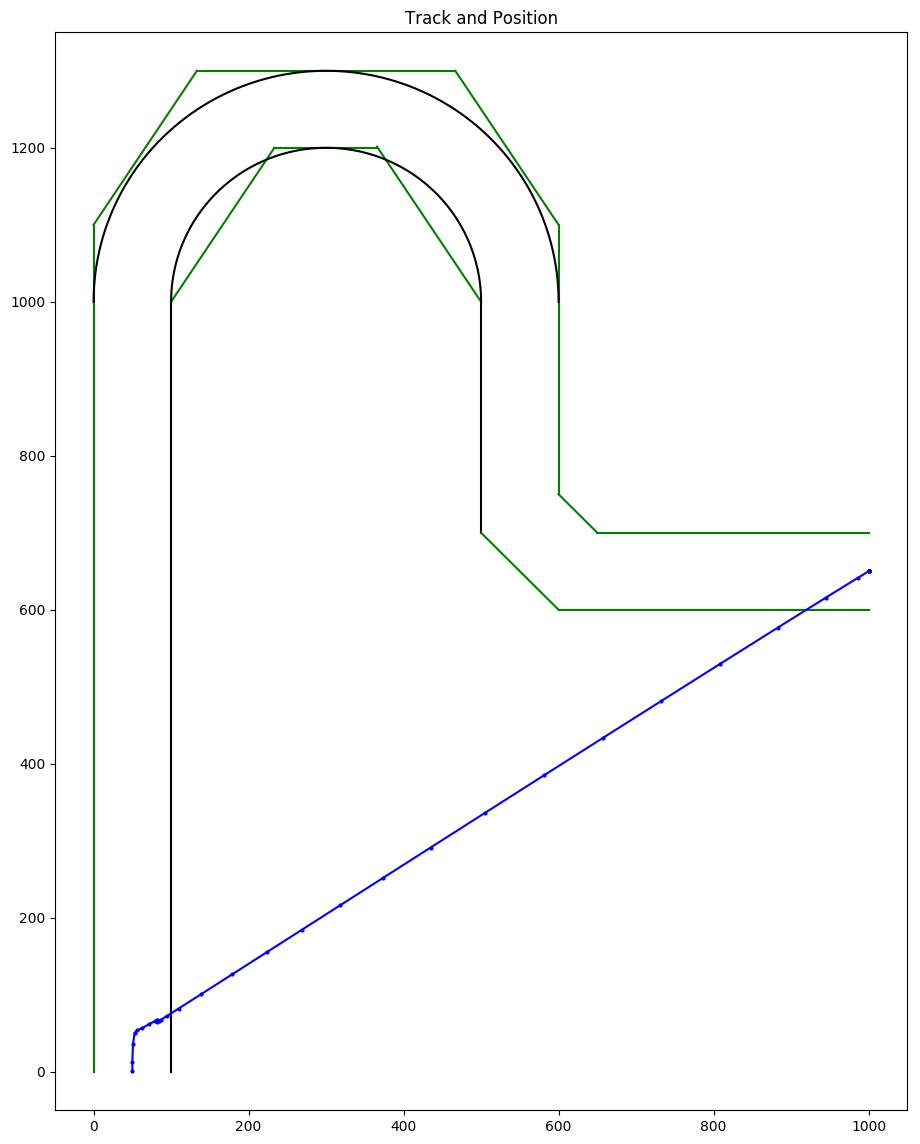

In [8]:
using JuMP, Gurobi, PyPlot
    raw = readcsv("Book3.csv")
    tx = length(raw[:,1])
    ty = length(raw[1,:])
raw[1,1] = 28
blankpos = [1 
50
0]
# blankpos[1,1] = 1
# blankpos[2,1] = 50
# blankpos[3,1] = 0

pos = FindPath(blankpos)

for j = 1:length(pos[1,:])
    
        round(Int64, pos[1,j])
        round(Int64, pos[2,j])
end

posCounter = 0

for i = 1:3
    
    for w = 1:length(pos[1,:])
        tempx =         round(Int64, pos[1,w])
          tempy =    round(Int64, pos[2,w])
                if tempx == 0
                tempx = tempx+1
            end
            if tempy == 0
                tempy = tempy+1
            end
            if raw[tempx, tempy] < 255 
                posCounter = posCounter+1
#                 print(w, ": IT GETS CALLED | ")
            end
    end
    if posCounter >= length(pos[1,:])
        CorPos = [zeros(posCounter)'; zeros(posCounter)';zeros(posCounter)']

        hits = 1
        
            for w = 1:length(pos[1,:])
                    tempx =  round(Int64, pos[1,w]) 
                    tempy =    round(Int64, pos[2,w]) 
                if tempx == 0
                tempx = tempx+1
            end
            if tempy == 0
                tempy = tempy+1
            end
                    posNumber = round(Int64, raw[tempx,tempy])
                if posNumber < 255
#                     println(hits)
                    CorPos[1,hits] = w
                    CorPos[2,hits] = pos[1,w]
                    CorPos[3,hits] = pos[2,w]
                    hits = round(Int64, hits + 1)
            
                end
            end
#         println(CorPos)
       pos = FindPath(CorPos)
    
    end
end


 


# ## Plotting everything
# #Plotting track (Position plots will also go in same figure)
rad = linspace(0,π,100) 
x = 300 + 200*cos.(rad)
y = 1000 + 200*sin.(rad)
x1 = 300 + 300*cos.(rad)
y1 = 1000 + 300*sin.(rad)
x2 = linspace(0,133.33,100)
x3 = linspace(100,233.33,100)
x4 = linspace(233.33,365.66,100)
x5 = linspace(133.33,466.66,100)
x6 = linspace(365.66,500,100)
x7 = linspace(466.66,600,100)
y2 = (3/2)*x2 + 1100
y3 = (3/2)*x3 + 850
y4 = 0*x4 + 1200
y5 = 0*x5 + 1300
y6 = -(3/2)*x6 + 1750
y7 = -(3/2)*x7 + 2000
x8 = linspace(0,0,2)
x9 = linspace(600,600,2)
y8 = linspace(0,1100,2)
y9 = linspace(750,1100,2)
x10 = linspace(500,600,100)
x11 = linspace(600,650,100)
x12 = linspace(600,1000,100)
x13 = linspace(650,1000,100)
y10 = -x10 + 1200
y11 = -x11 + 1350
y12 = 0*x12 + 600
y13 = 0*x13 + 700

Llinex = [0, 0]
Lliney = [0, 1000]
LMlinex = [100,100]
LMliney = [0,1000]
RMlinex = [500, 500]
RMliney = [700,1000]
Rlinex = [600,600]
Rliney = [750,1000]
figure(figsize=(11,14))
title("Track and Position")
#Track
plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
plot(x2,y2, "g-", markersize=4 )
plot(x3,y3, "g-", markersize=4 )
plot(x4,y4, "g-", markersize=4 )
plot(x5,y5, "g-", markersize=4 )
plot(x6,y6, "g-", markersize=4 )
plot(x7,y7, "g-", markersize=4 )
plot(x8,y8, "g-", markersize=4 )
plot(x9,y9, "g-", markersize=4 )
plot(x10,y10, "g-", markersize=4 )
plot(x11,y11, "g-", markersize=4 )
plot(x12,y12, "g-", markersize=4 )
plot(x13,y13, "g-", markersize=4 )
plot(x,y, color = "#000000", markersize=4 )
plot(x1,y1, color = "#000000", markersize=4 )
#Position
plot( pos[1,:],pos[2,:], "b.-", markersize=4 )
axis((-50,1050,-50,1350));

# figure(figsize=(12,4))
# title("velocity x")
# plot( getvalue(v[1,:]), "b.", markersize=2 )

# figure(figsize=(12,4))
# title("velocity y")
# plot( getvalue(v[2,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in direction of motion x")
# plot( getvalue(AccDM[1,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in direction of motion y")
# plot( getvalue(AccDM[2,:]), "b-", markersize=2 )


# figure(figsize=(12,4))
# title("Acceleration centripital")
# plot( getvalue((AccCent[1,:].^2)+(AccCent[2,:].^2)), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in centripital of motion x")
# plot( getvalue(AccCent[1,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in centripital of motion y")
# plot( getvalue(AccCent[2,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("AccDMBeta")
# plot( getvalue(AccDMBeta), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Thrust")
# plot( getvalue(Thrust), "b-", markersize=2 )



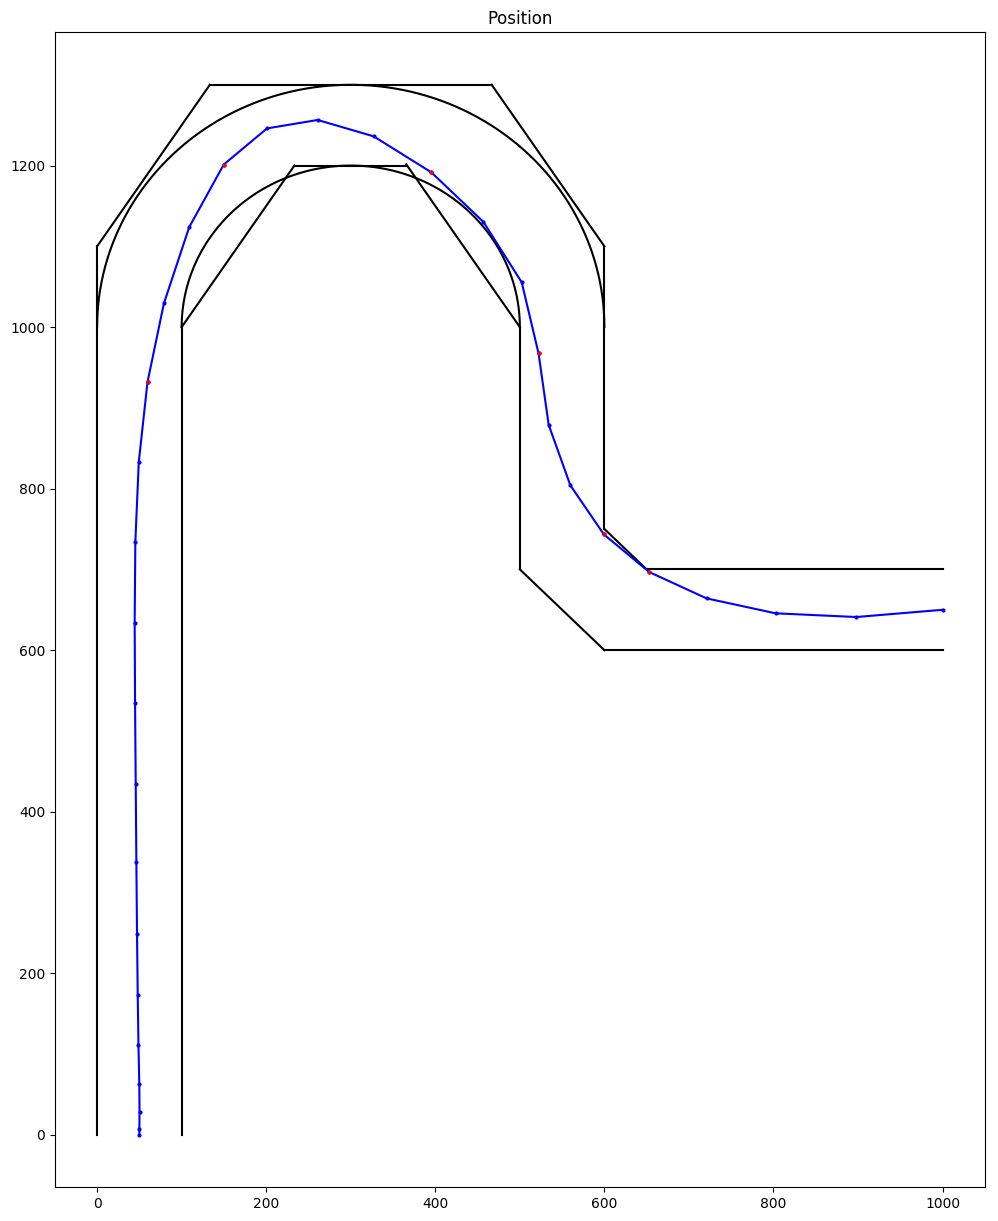

Academic license - for non-commercial use only


In [5]:
using JuMP, Gurobi, Mosek, PyPlot
coflo = 0.2 #coeffecient of friction longitudnal(in direction of motion)
cofla = 0.4 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)


## car specs all specs in meters and seconds
# mass = 1000 # in kg
g = 9.8  # gravitational pull in m/sec^2
maxacc = 14.2  # max acc in m/sec^2
maxv = 103.5 # max velocity in m/sec equivalent to 200km/hr
maxTu = 1.27 #max steer one side

k = 32
startPos = [50,0]
finishPos = [1000, 650]
startVel = [0,0]
finishVel = [0,0]
finishAcc = [0,0]


    # define waypoints
    m = Model(solver = GurobiSolver(OutputFlag=0))
#     m = Model(solver = MosekSolver(LOG=0))
    
    @variable(m, P[1:2,1:k])  # resulting position in x,y
    @variable(m, v[1:2,1:k])
    @variable(m, -(2.75*maxacc) <= Acc[1:2,1:k] <= maxacc )

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, P[:,1] .== startPos)
    @constraint(m, P[:,k] .== finishPos)
    @constraint(m, v[:,1] .== startVel)
    # @constraint(m, v[:,k] .== finishVel)
    # @constraint(m, AccDM[:,k] .== finishAcc)
    @expression(m, finishDistance, sum((P[i,k]-finishPos[i])^2 for i in 1:2))


    for t in 1:14
        @constraint(m, P[1,t] <= 100)
    end
    for t in 1:25
        @constraint(m, P[2,t] <= -(3/2)*P[1,t] + 1900)
    end
    for t in 15:16
        @constraint(m, P[2,t] >= 50+(3/2)*P[1,t] + 850)
    end
    for t in 17:19
        @constraint(m, P[2,t] >= 1200)
#         @constraint(m, P[2,t] >= -(3/2)*P[1,t] + 1750)
    end
    for t in 21:24
        @constraint(m, P[2,t] >= -(3/2)*P[1,t] + 1750)
    end
    for t in 24:27
        @constraint(m, P[1,t] >= 500)
         @constraint(m, P[1,t] <= 600)

    end
    for t in 28
        @constraint(m, P[1,t] >= 500)
        @constraint(m, P[2,t] <= -1*P[1,t] + 1350)
        @constraint(m, P[2,t] >= -1*P[1,t] + 1200)
    end
    for t in 29:k
        @constraint(m, P[2,t] <=700)
        @constraint(m, P[2,t] >= 600)
    end


    for t in 1:k
        @constraint(m, (v[1,t]^2)+(v[2,t]^2) <= maxv^2)
        @constraint(m, P[1,t] >= 0)
        @constraint(m, P[1,t] <= 1001)
        @constraint(m, P[2,t] >= 0)
        @constraint(m, P[2,t] <= 2300)
        @constraint(m, P[2,t] <= (3/2)*P[1,t] + 1100)
        @constraint(m, P[2,t] <= 1300)
    end

    for t in 1:k-1
#         @constraint(m, Acc[:,t+1] .== Acc[:,t] 
        @constraint(m, v[1,t+1] == v[1,t] + Acc[1,t])
        @constraint(m, v[2,t+1] == v[2,t] + Acc[2,t])
        @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*(Acc[1,t]) )
        @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*(Acc[2,t])  )   
    end


                
                
     @objective(m, Min, finishDistance)               
    solve(m)
    
rad = linspace(0,π,100) 

x = 300 + 300*cos.(rad)
y = 1000 +300*sin.(rad)
x1 = 300 + 200*cos.(rad)
y1 = 1000 + 200*sin.(rad)

x2 = linspace(0,133.33,100)
x3 = linspace(100,233.33,100)
x4 = linspace(233.33,365.66,100)
x5 = linspace(133.33,466.66,100)
x6 = linspace(365.66,500,100)
x7 = linspace(466.66,600,100)
x8 = linspace(500,600,100)
x9 = linspace(600,650,100)
x10 = linspace(600,1000,100)
x11 = linspace(650,1000,100)

y2 = (3/2)*x2 + 1100
y3 = (3/2)*x3 + 850
y4 = 0*x4 + 1200
y5 = 0*x5 + 1300
y6 = -(3/2)*x6 + 1750
y7 = -(3/2)*x7 + 2000
y8 = -x8 + 1200
y9 = -x9 + 1350
y10 = 0*x11 + 600
y11 = 0*x11 + 700

Llinex = [0, 0]
Lliney = [0, 1100]
LMlinex = [100,100]
LMliney = [0,1000]
RMlinex = [500, 500]
RMliney = [700,1000]
Rlinex = [600,600]
Rliney = [750,1100]

figure(figsize=(12,15))
title("Position")

plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
plot(x,y, color = "#000000", markersize=4 )
plot(x1,y1, color = "#000000", markersize=4 )
plot(x2,y2, color = "#000000", markersize=4 )
plot(x3,y3, color = "#000000", markersize=4 )
plot(x4,y4, color = "#000000", markersize=4 )
plot(x5,y5, color = "#000000", markersize=4 )
plot(x6,y6, color = "#000000", markersize=4 )
plot(x7,y7, color = "#000000", markersize=4 )
plot(x8,y8, color = "#000000", markersize=4 )
plot(x9,y9, color = "#000000", markersize=4 )
plot(x10,y10, color = "#000000", markersize=4 )
plot(x11,y11, color = "#000000", markersize=4 )

plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 );

    plot( getvalue(P[1,14]), getvalue(P[2,14]), "r.", markersize=4 );
    plot( getvalue(P[1,17]), getvalue(P[2,17]), "r.", markersize=4 );
    plot( getvalue(P[1,21]), getvalue(P[2,21]), "r.", markersize=4 );
    plot( getvalue(P[1,24]), getvalue(P[2,24]), "r.", markersize=4 );
    plot( getvalue(P[1,27]), getvalue(P[2,27]), "r.", markersize=4 );
    plot( getvalue(P[1,28]), getvalue(P[2,28]), "r.", markersize=4 );

In [50]:
using JuMP, Gurobi, PyPlot
    raw = readcsv("Book3.csv")
    tx = 5 #length(raw[1:5,1])
    ty = 5 #length(raw[1,1:5])
raw[1,1] = 28
#   for j = 1:ty
# for i = 1:tx    
# #         print([raw[i,j]])
#     end
#     end
raw[1,1] = 28
    m = Model(solver=GurobiSolver(OutputFlag=0))
    
    t = 5

#     x = [1:tx, 1:ty]
    @variable(m, track[1:tx, 1:ty], Int)
    @variable(m, position[1:2,1:3] >= 0)
  for j = 1:ty
    for i = 1:tx
            @constraint(m,track[i,j] <= raw[i,j] )
            @constraint(m,track[i,j] >= raw[i,j] )
        end
    end
  @constraint(m,position[1,2] == 27.0 )
for w = 1:3
  for j = 1:ty
    for i = 1:tx
#             println([getvalue(track[1,2])])
        if track[i,j]-1 == position[1,w]# || track[i,j] >= position[1,w]
#                 @constraint(m,track[i,j] <= raw[i,j] )
                @constraint(m,track[i,j] == 85 )
                println("OMG")
            end
        end
    end
end
@objective(m, Min, sum(position[1,i] for i in 1:3))

print("cleared")
#     @expression(m, reg, sum(((newVolt[i] - newVolt[i-1])^2) for i in 2:t))
#     @objective(m, Min, sum((newVolt - x).^2)) 
    solve(m)
  println([getvalue(position[1,2])])
  for j = 1:ty
for i = 1:tx    
        print([getvalue(track[i,j])])
    end
    end

clearedAcademic license - for non-commercial use only
[27.0]
[28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0][28.0]

In [ ]:






    
    
    
## Plotting everything
#Plotting track (Position plots will also go in same figure)
rad = linspace(0,π,100) 
x = 300 + 200*cos.(rad)
y = 1000 + 200*sin.(rad)
x1 = 300 + 300*cos.(rad)
y1 = 1000 + 300*sin.(rad)
x2 = linspace(0,133.33,100)
x3 = linspace(100,233.33,100)
x4 = linspace(233.33,365.66,100)
x5 = linspace(133.33,466.66,100)
x6 = linspace(365.66,500,100)
x7 = linspace(466.66,600,100)
y2 = (3/2)*x2 + 1100
y3 = (3/2)*x3 + 850
y4 = 0*x4 + 1200
y5 = 0*x5 + 1300
y6 = -(3/2)*x6 + 1750
y7 = -(3/2)*x7 + 2000
x8 = linspace(0,0,2)
x9 = linspace(600,600,2)
y8 = linspace(0,1100,2)
y9 = linspace(750,1100,2)
x10 = linspace(500,600,100)
x11 = linspace(600,650,100)
x12 = linspace(600,1000,100)
x13 = linspace(650,1000,100)
y10 = -x10 + 1200
y11 = -x11 + 1350
y12 = 0*x12 + 600
y13 = 0*x13 + 700

Llinex = [0, 0]
Lliney = [0, 1000]
LMlinex = [100,100]
LMliney = [0,1000]
RMlinex = [500, 500]
RMliney = [700,1000]
Rlinex = [600,600]
Rliney = [750,1000]
figure(figsize=(11,14))
title("Track and Position")
#Track
plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
plot(x2,y2, "g-", markersize=4 )
plot(x3,y3, "g-", markersize=4 )
plot(x4,y4, "g-", markersize=4 )
plot(x5,y5, "g-", markersize=4 )
plot(x6,y6, "g-", markersize=4 )
plot(x7,y7, "g-", markersize=4 )
plot(x8,y8, "g-", markersize=4 )
plot(x9,y9, "g-", markersize=4 )
plot(x10,y10, "g-", markersize=4 )
plot(x11,y11, "g-", markersize=4 )
plot(x12,y12, "g-", markersize=4 )
plot(x13,y13, "g-", markersize=4 )
plot(x,y, color = "#000000", markersize=4 )
plot(x1,y1, color = "#000000", markersize=4 )
#Position
plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 )
plot( getvalue(P[1,20]), getvalue(P[2,20]), "r.", markersize=4 )
axis((-50,1050,-50,1350));

# figure(figsize=(12,4))
# title("velocity x")
# plot( getvalue(v[1,:]), "b.", markersize=2 )

# figure(figsize=(12,4))
# title("velocity y")
# plot( getvalue(v[2,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in direction of motion x")
# plot( getvalue(AccDM[1,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in direction of motion y")
# plot( getvalue(AccDM[2,:]), "b-", markersize=2 )


# figure(figsize=(12,4))
# title("Acceleration centripital")
# plot( getvalue((AccCent[1,:].^2)+(AccCent[2,:].^2)), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in centripital of motion x")
# plot( getvalue(AccCent[1,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Acceleration in centripital of motion y")
# plot( getvalue(AccCent[2,:]), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("AccDMBeta")
# plot( getvalue(AccDMBeta), "b-", markersize=2 )

# figure(figsize=(12,4))
# title("Thrust")
# plot( getvalue(Thrust), "b-", markersize=2 )